# Transfer Learning - Scaling Up

In [21]:
# Importing TF and checking the version
import tensorflow as tf

print(tf.__version__)

2.10.1


In [2]:
# Importing custom helper functions
from DanielBourke_HelperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

In [3]:
# Setting data directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
# How many images are we dealing with
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [5]:
# Setting up data inputs
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False # Don't shuffle test data
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
# Creating checkpoint callback
checkpoint_path = "101_food_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [7]:
# Creating data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    # preprocessing.Rescaling(1./255) - for models, that don't auto-rescale
], name="data_augmentation")

In [8]:
# Setting up the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting up layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(
    len(train_data_all_10_percent.class_names),
    activation="softmax",
    name="output_layer"
)(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
# Getting the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [10]:
# Compiling the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fitting the model
history = model.fit(
    train_data_all_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.25 * len(test_data_all_10_percent)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 1225s 5s/step - loss: 3.3725 - accuracy: 0.2776 - val_loss: 2.4649 - val_accuracy: 0.4438
Epoch 2/5
237/237 [==============================] - 1159s 5s/step - loss: 2.1925 - accuracy: 0.5001 - val_loss: 2.0634 - val_accuracy: 0.4884
Epoch 3/5
237/237 [==============================] - 1141s 5s/step - loss: 1.8261 - accuracy: 0.5679 - val_loss: 1.9072 - val_accuracy: 0.5102
Epoch 4/5
237/237 [==============================] - 1462s 6s/step - loss: 1.5953 - accuracy: 0.6116 - val_loss: 1.8082 - val_accuracy: 0.5246
Epoch 5/5
237/237 [==============================] - 2234s 9s/step - loss: 1.4455 - accuracy: 0.6467 - val_loss: 1.7944 - val_accuracy: 0.5227


In [11]:
# Evaluating on the whole dataset
feature_extraction_results = model.evaluate(test_data_all_10_percent)
feature_extraction_results

790/790 [==============================] - 1935s 2s/step - loss: 1.5829 - accuracy: 0.5815


[1.5828746557235718, 0.5814653635025024]

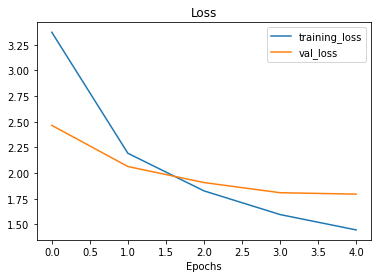

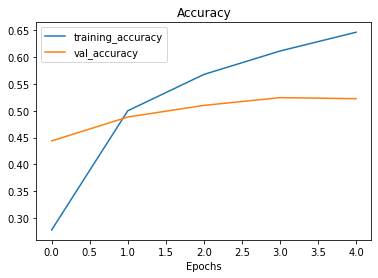

In [12]:
# Visualising the loss curves
plot_loss_curves(history=history)

### Fine-Tuning

In [13]:
# Unfreeze all layers
base_model.trainable = True

# Refreeze all layers except for the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [14]:
# Recompiling the model with a lower learning rate
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [15]:
# Checking which layers are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [16]:
# Checking which layers are trainable in the base model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [17]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

history_finetuned = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    initial_epoch=history.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 979s 4s/step - loss: 1.2209 - accuracy: 0.6785 - val_loss: 1.6699 - val_accuracy: 0.5556
Epoch 6/10
237/237 [==============================] - 978s 4s/step - loss: 1.0820 - accuracy: 0.7085 - val_loss: 1.6735 - val_accuracy: 0.5561
Epoch 7/10
237/237 [==============================] - 1029s 4s/step - loss: 0.9993 - accuracy: 0.7304 - val_loss: 1.6773 - val_accuracy: 0.5559
Epoch 8/10
237/237 [==============================] - 415s 2s/step - loss: 0.9482 - accuracy: 0.7485 - val_loss: 1.6576 - val_accuracy: 0.5636
Epoch 9/10
237/237 [==============================] - 385s 2s/step - loss: 0.8947 - accuracy: 0.7599 - val_loss: 1.6672 - val_accuracy: 0.5609
Epoch 10/10
237/237 [==============================] - 381s 2s/step - loss: 0.8370 - accuracy: 0.7752 - val_loss: 1.6735 - val_accuracy: 0.5567


In [18]:
# Evaluating on the whole test dataset
fine_tuning_results = model.evaluate(test_data_all_10_percent)
fine_tuning_results

790/790 [==============================] - 777s 983ms/step - loss: 1.4927 - accuracy: 0.6017


[1.4926910400390625, 0.6017425656318665]

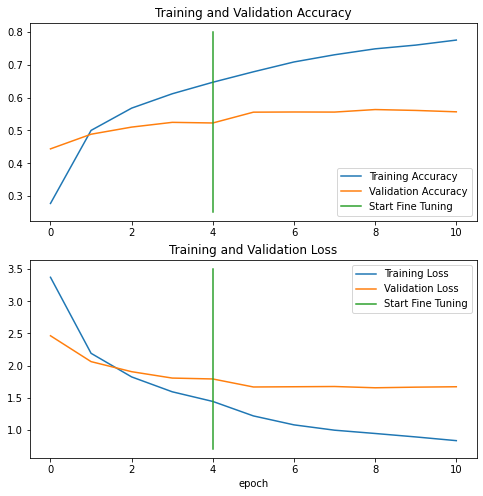

In [19]:
# Comparing histories
compare_historys(
    original_history=history,
    new_history=history_finetuned,
    initial_epochs=5
)

In [24]:
# Saving fine-tuned model
tf.keras.models.save_model(model=model, filepath="saved_model/finetuned_10p")
#model.save("saved_model/finetuned_10p")

INFO:tensorflow:Assets written to: saved_model/finetuned_10p\assets


INFO:tensorflow:Assets written to: saved_model/finetuned_10p\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [25]:
# Loading saved model
loaded_model = tf.keras.models.load_model("saved_model/finetuned_10p")

ValueError: Unable to create a Keras model from SavedModel at saved_model/finetuned_10p. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

### Making predictions

In [27]:
# Checking model prediction probabilities
preds_probs = model.predict(test_data_all_10_percent, verbose=1)

790/790 [==============================] - 21890s 28s/step


In [28]:
# Shape of predictions
preds_probs.shape

(25250, 101)

In [29]:
# First 10 predictions
preds_probs[:10]

array([[2.4520439e-01, 6.6030014e-04, 1.5364882e-01, ..., 1.5951309e-05,
        9.5612854e-03, 5.2355960e-02],
       [9.4483382e-01, 2.4581739e-08, 7.6244108e-04, ..., 7.4241916e-03,
        4.4293387e-07, 4.8142811e-06],
       [3.8913009e-01, 8.9338757e-03, 9.6814828e-03, ..., 2.7615897e-04,
        2.5842132e-04, 2.5166450e-03],
       ...,
       [1.9061100e-01, 4.3152745e-06, 9.4549119e-04, ..., 5.0116096e-02,
        4.1353478e-04, 6.8879846e-05],
       [1.9513334e-01, 4.5685991e-04, 4.1934323e-01, ..., 6.3504284e-04,
        1.8787663e-04, 1.9426418e-04],
       [7.0803684e-01, 5.6954229e-07, 1.1571508e-03, ..., 3.8240405e-03,
        2.9486791e-06, 7.0045923e-04]], dtype=float32)

In [30]:
# Getting predictions per class
print(f"Number of prediction probabiliyies: {len(preds_probs[0])}")
print(f"What prediction 0 looks like:\n {preds_probs[0]}")
print(f"What is the highest probability {preds_probs[0].argmax()}")

Number of prediction probabiliyies: 101
What prediction 0 looks like:
 [2.45204389e-01 6.60300138e-04 1.53648823e-01 1.51441199e-07
 8.78110131e-06 2.66573647e-06 5.93937257e-05 1.70742214e-06
 1.21419011e-02 2.91816512e-04 1.67580663e-06 1.79251347e-05
 9.91179724e-04 2.41212945e-07 5.79254655e-03 3.23136989e-03
 1.64254525e-05 1.01466558e-03 7.60043971e-03 4.42072633e-05
 4.37082781e-04 1.27853982e-05 2.30713136e-04 4.53989924e-04
 8.45291768e-04 1.75294583e-03 9.22289444e-04 1.27233157e-04
 1.36961371e-01 9.60593636e-04 3.49654715e-06 5.96431375e-04
 6.80745346e-04 1.14638112e-06 6.74583483e-03 1.77801121e-05
 1.11922374e-04 2.46341038e-03 4.16875668e-02 1.75295820e-04
 9.59721860e-04 4.21662349e-03 1.33111083e-03 1.40534003e-05
 4.16725779e-05 6.21299841e-05 4.27900394e-03 8.86793423e-05
 3.56066471e-06 4.85642478e-02 2.92460638e-04 1.27409716e-04
 1.01904690e-01 2.92862840e-02 4.33360947e-05 2.28237268e-03
 1.12251397e-02 1.30884896e-03 4.11906745e-03 5.78511244e-05
 8.99919883e-0

In [31]:
# Getting all predicted classes
pred_classes = preds_probs.argmax(axis=1)

# Checking first 10 predictions
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  2,  0], dtype=int64)

In [33]:
# How many classes we have
len(pred_classes)

25250

In [36]:
# Extracting test labels
y_labels = []

for images, labels in test_data_all_10_percent.unbatch():
    y_labels.append(labels.numpy().argmax())

# Checking the first 10
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:
# Checking accuracy score
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6017425742574257

In [38]:
# Checking if accuracy metrics are close
import numpy as np

np.isclose(fine_tuning_results[1], sklearn_accuracy)

True

In [39]:
# Test data class names
class_names = test_data_all_10_percent.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

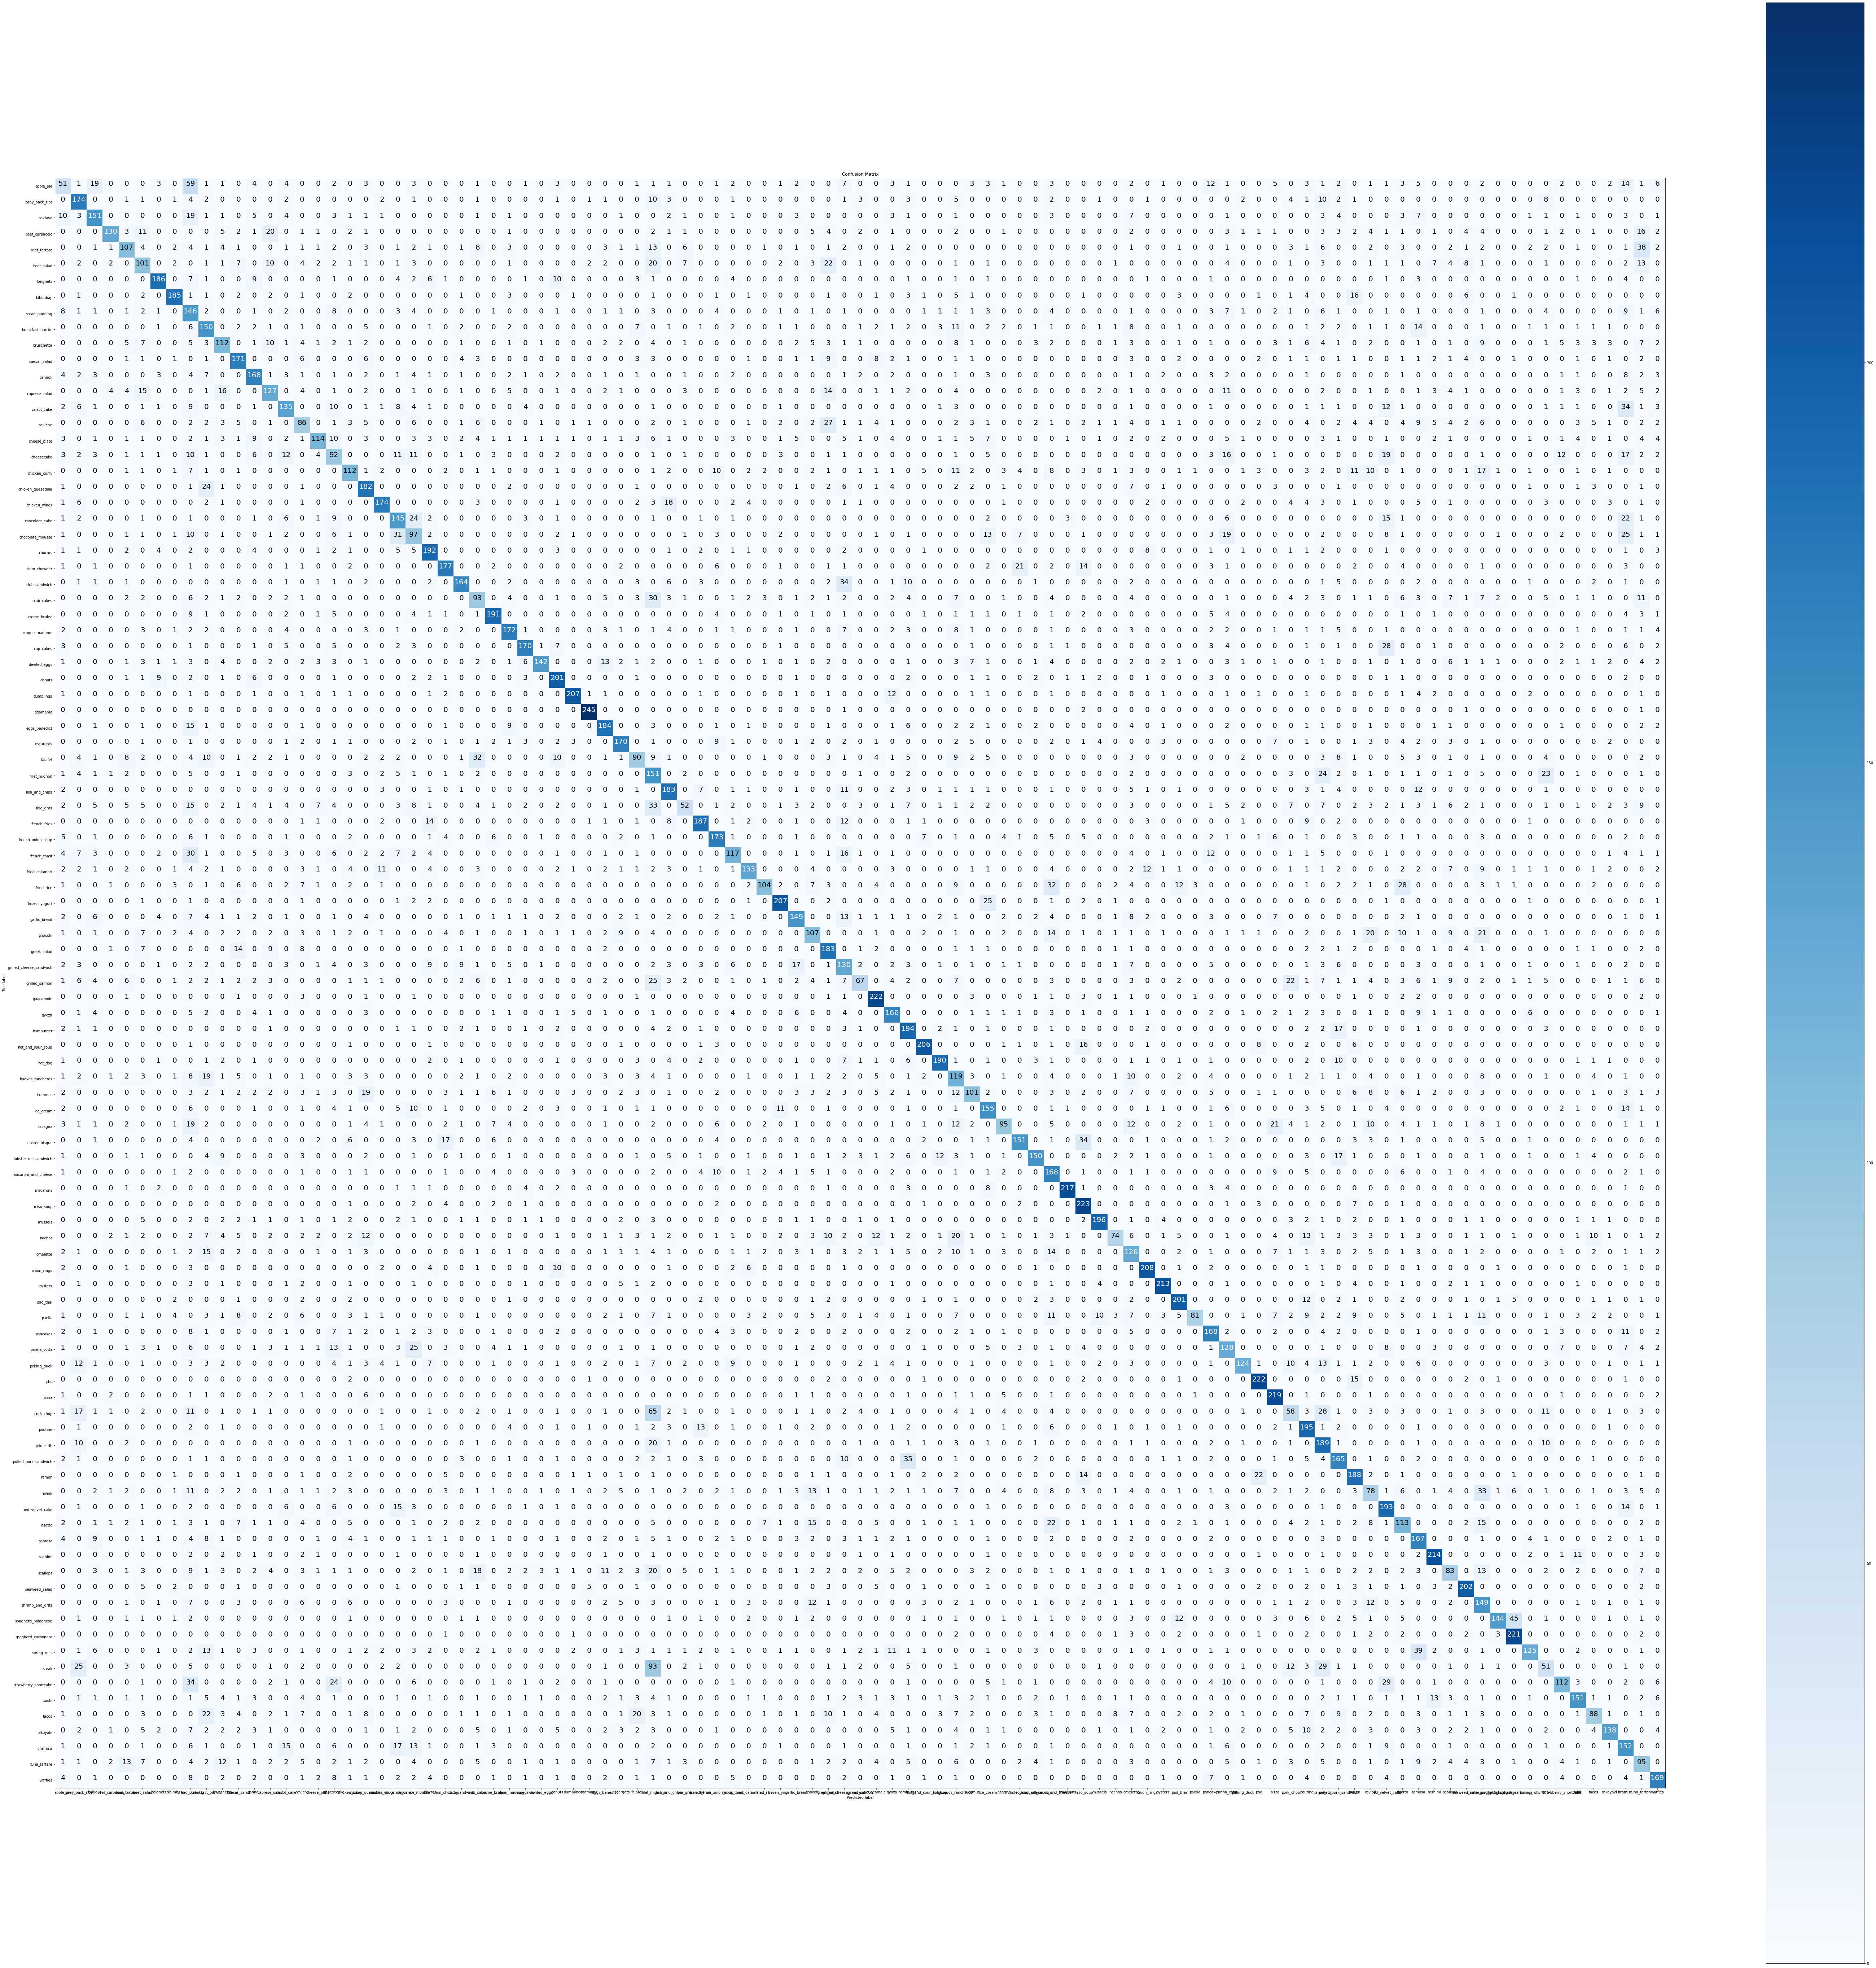

In [41]:
# Visualising confusion matrix
from DanielBourke_HelperFunctions import make_confusion_matrix

make_confusion_matrix(
    y_true=y_labels,
    y_pred=pred_classes,
    classes=class_names,
    figsize=(100, 100),
    text_size=20
)